In [1]:
%matplotlib inline
import math
import os
from itertools import count, groupby
from operator import itemgetter

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.distributions import Bernoulli, Normal
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from pytorch_lightning import LightningModule, Trainer

In [2]:
@torch.no_grad()
def get_digit_samples():
    by_digit = itemgetter(1)

    mnist = MNIST(os.getcwd(), transform=ToTensor())
    mnist = sorted(mnist, key=by_digit)
    mnist = groupby(mnist, key=by_digit)

    samples = []
    for digit, grp in mnist:
        x, y = next(grp)
        samples.append(x.view(-1))

    return torch.stack(samples)


@torch.no_grad()
def sweep_variable_across_samples(vae, samples, i, sweep):
    """Sweeps a single latent variable
    
    Arguments
    ---------
    vae : torch.Module
        A VAE module; must have a decode method
    samples : n-by-z array-like
        Contains n samples of z latent variables
    i : int < z
        The latent variable to sweep
    sweep : array
        The values to use in sweeping z
    """
    # XXX dumb, unvectorized version
    recons = []
    for sample in samples:
        recons.append([])
        for val in sweep:
            sample[i] = val
            # Use just means as image
            img, _ = vae.decode(sample)
            recons[-1].append(img.detach().numpy())
    return np.array(recons)


@torch.no_grad()
def plot_sweep_grid(origs, recons, sweepvals):
    idx = count(1)
    fig = plt.figure(figsize=(15, 13))
    fig.subplots_adjust(hspace=0, wspace=0)
    for i in range(10):
        plt.subplot(10, 11, next(idx))
        plt.imshow(origs[i].reshape(28, 28))
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.title('Orig')
        for j in range(10):
            plt.subplot(10, 11, next(idx))
            plt.imshow(recons[i][j].reshape(28, 28))
            plt.xticks([])
            plt.yticks([])
            if i == 0:
                plt.title(f'{sweepvals[j]:.2f}')
    plt.show()
    
@torch.no_grad()
def plot_all_sweeps(model):
    digits = get_digit_samples()
    digit_encodings, *_ = model(digits)
    sweep_range = torch.linspace(-4, 4, steps=10)
    
    return digit_encodings, sweep_range
#     for i in range(20):
    for i in range(1):
        print(f'Sweeping reconstructions over latent variable no. {i}')
        recons_by_var = sweep_variable_across_samples(model,
                                                      digit_encodings.clone(),
                                                      i,
                                                      sweep_range)
        plot_sweep_grid(digits.detach().numpy(), recons_by_var, sweep_range)
    return digit_encodings, sweep_range

@torch.no_grad()
def zeroth_mu_sigma(enc, model):
    m, s = model.decode(enc)
    s = F.softplus(s)
    
    m0, s0 = m[0], s[0]
    
    plt.subplot(221)
    plt.imshow(m0.reshape(28, 28), norm=None, cmap='gray', vmin=0.0, vmax=1.0)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(222)
    plt.imshow(s0.reshape(28, 28), norm=None, cmap='gray', vmin=0.0, vmax=1.0)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(223)
    plt.imshow(m0.reshape(28, 28))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(224)
    plt.imshow(s0.reshape(28, 28))
    plt.xticks([])
    plt.yticks([])
    
    plt.show()
    return m, s

In [3]:
!ls -la betavae_tests

total 1152
drwxr-xr-x  8 stilljm staff     256 Apr 13 15:02 .
drwxr-xr-x 22 stilljm staff     704 Apr 13 16:45 ..
drwxr-xr-x  4 stilljm staff     128 Apr 13 15:01 MNIST
drwxr-xr-x  8 stilljm staff     256 Apr 13 15:00 checkpoints
drwxr-xr-x  8 stilljm staff     256 Apr 13 15:02 lightning_logs
-rw-------  1 stilljm staff 1166495 Apr 13 15:01 nohup.out
-rwxr-xr-x  1 stilljm staff     377 Apr 13 15:02 run.sh
-rw-r--r--  1 stilljm staff    4097 Apr 13 15:01 train.py


In [4]:
from betavae_tests.train import MnistBetaVAE

# Recons

In [5]:
with torch.no_grad():
    digits = get_digit_samples()
    swp = torch.linspace(-4, 4, steps=10)

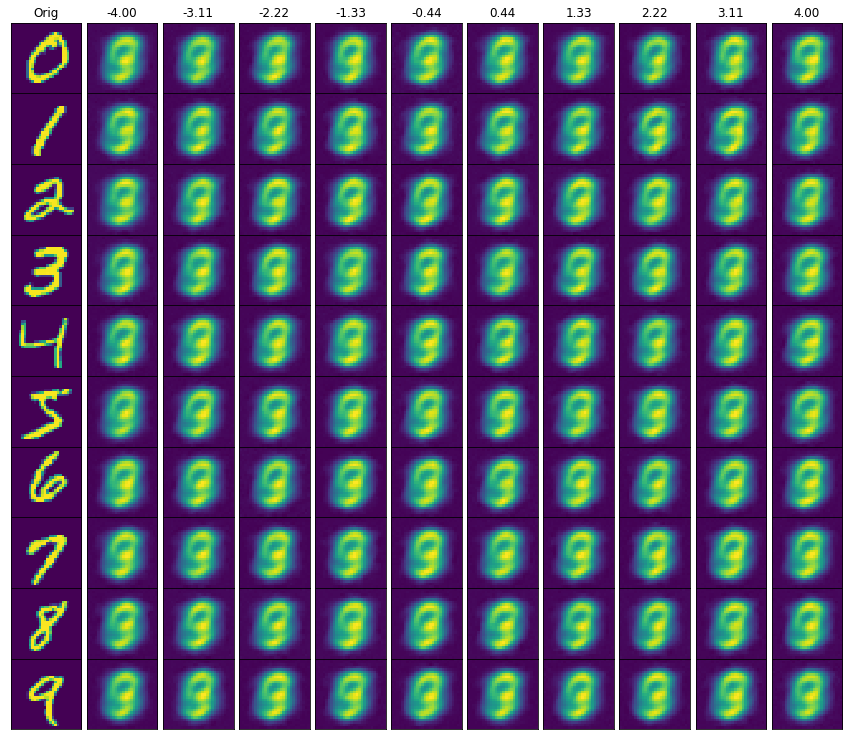

In [6]:
model_b1 = model = MnistBetaVAE.load_from_checkpoint('betavae_tests/checkpoints/model-beta-1.0.ckpt')

with torch.no_grad():
    enc, *_  = model(digits)
    recons = sweep_variable_across_samples(model, enc.clone(), 0, swp)
    plot_sweep_grid(digits.detach().numpy(), recons, swp)

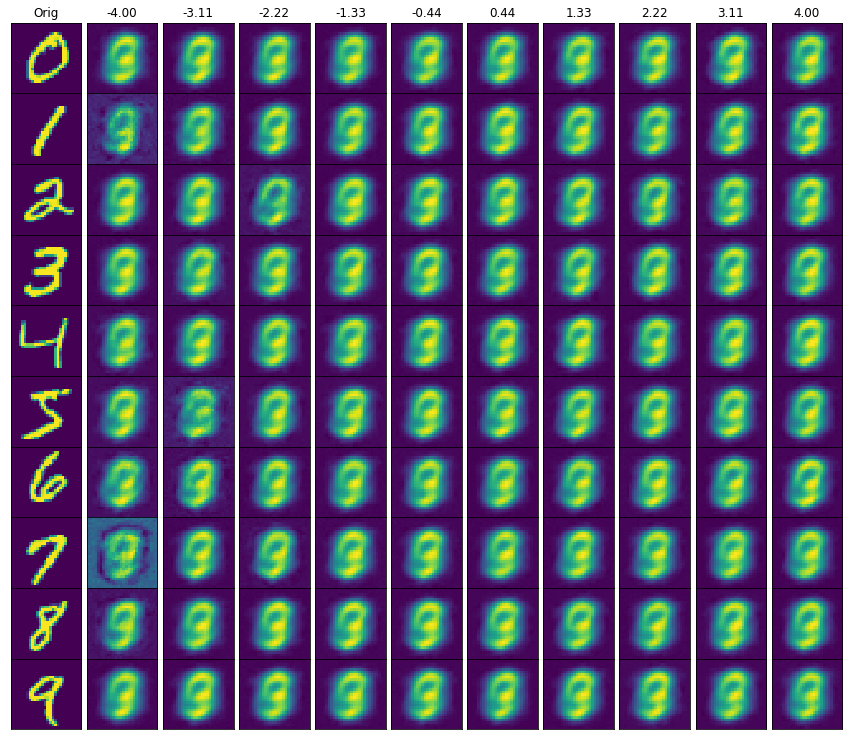

In [7]:
model_b0 = model = MnistBetaVAE.load_from_checkpoint('betavae_tests/checkpoints/model-beta-0.0.ckpt')

with torch.no_grad():
    enc, *_ = model(digits)
    recons = sweep_variable_across_samples(model, enc.clone(), 0, swp)
    plot_sweep_grid(digits.detach().numpy(), recons, swp)

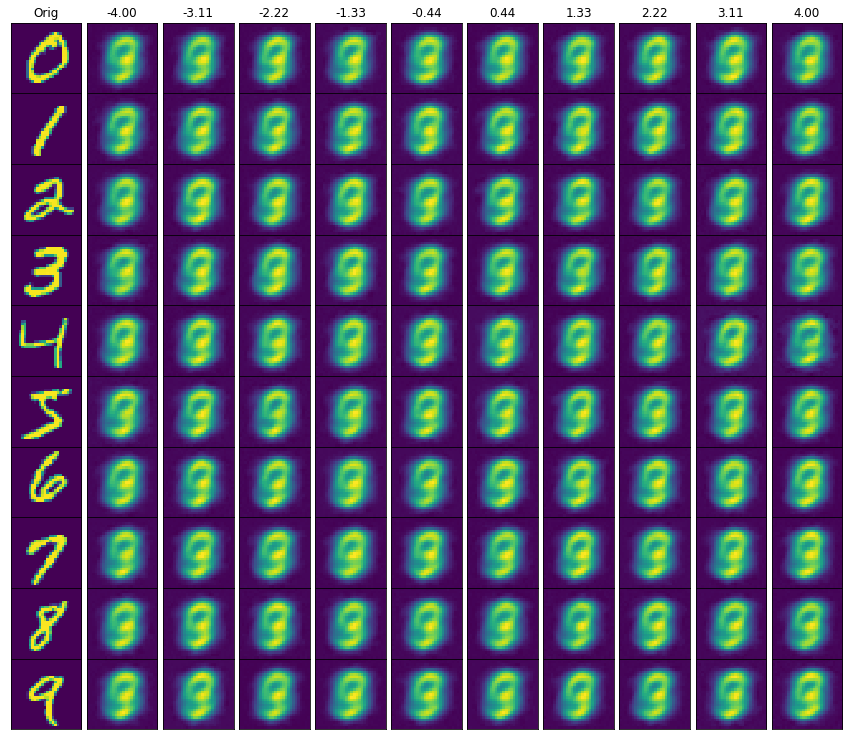

In [8]:
model_b_small = model = MnistBetaVAE.load_from_checkpoint('betavae_tests/checkpoints/model-beta-0.0001.ckpt')

with torch.no_grad():
    enc, *_ = model(digits)
    recons = sweep_variable_across_samples(model, enc.clone(), 0, swp)
    plot_sweep_grid(digits.detach().numpy(), recons, swp)

In [9]:
with torch.no_grad():
    mnist = MNIST(os.getcwd(), transform=ToTensor())
    mnist = torch.stack([x.view(-1) for x, _ in mnist])
    
    z_b1, z_b1_mu, z_b1_scale, x, x_b1_mu, x_b1_scale = model_b1(mnist)
    z_b1_std = 1e-6 + F.softplus(z_b1_scale)
    x_b1_std = 1e-6 + F.softplus(x_b1_scale)
    
    z_b0, z_b0_mu, z_b0_scale, x, x_b0_mu, x_b0_scale = model_b0(mnist)
    z_b0_std = 1e-6 + F.softplus(z_b0_scale)
    x_b0_std = 1e-6 + F.softplus(x_b0_scale)
    
    z_bsmall, z_bsmall_mu, z_bsmall_scale, x, x_bsmall_mu, x_bsmall_scale = model_b_small(mnist)
    z_bsmall_std = 1e-6 + F.softplus(z_bsmall_scale)
    x_bsmall_std = 1e-6 + F.softplus(x_bsmall_scale)

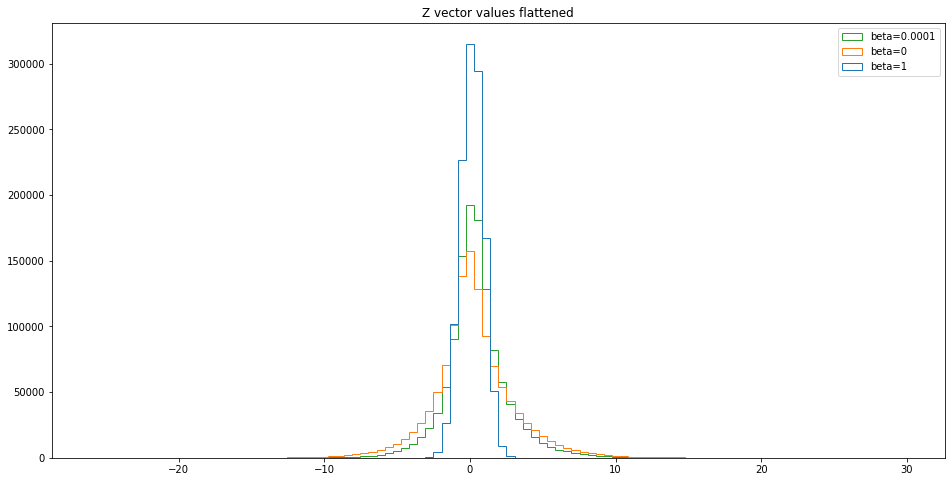

In [10]:
plt.figure(figsize=(16, 8))
plt.title('Z vector values flattened')
plt.hist([z_b1.view(-1).numpy(), 
          z_b0.view(-1).numpy(), 
          z_bsmall.view(-1).numpy()], 
         bins=100, 
         histtype='step',
         label=['beta=1', 'beta=0', 'beta=0.0001'])
plt.legend()
plt.show()

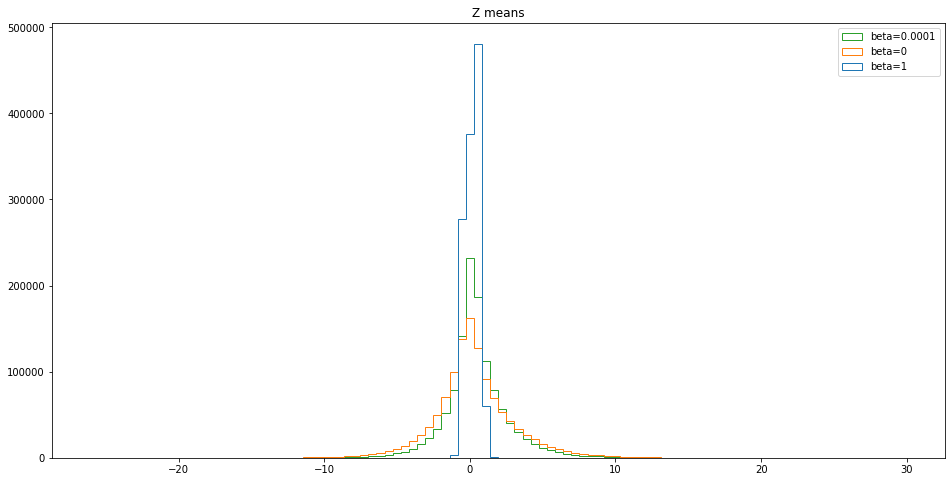

In [11]:
plt.figure(figsize=(16, 8))
plt.title('Z means')
plt.hist([z_b1_mu.view(-1).numpy(), 
          z_b0_mu.view(-1).numpy(), 
          z_bsmall_mu.view(-1).numpy()], 
         bins=100, 
         histtype='step',
         label=['beta=1', 'beta=0', 'beta=0.0001'])
plt.legend()
plt.show()

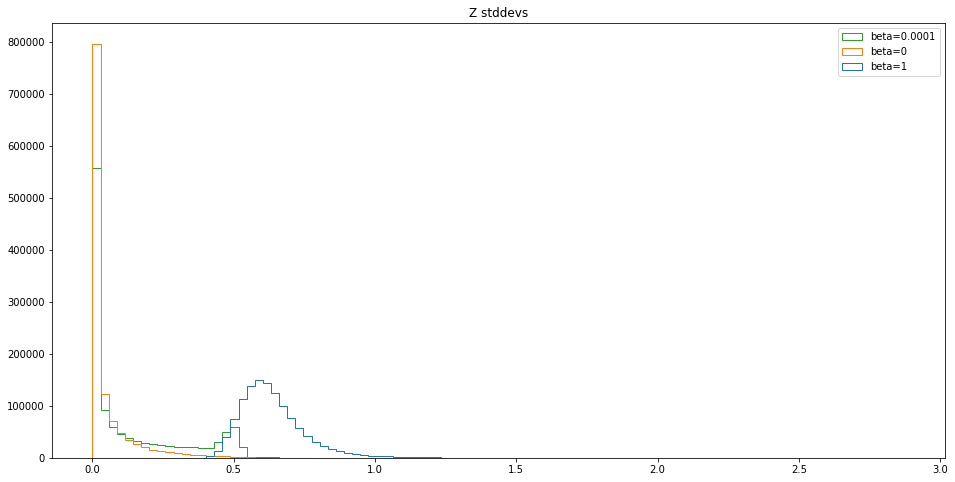

In [12]:
plt.figure(figsize=(16, 8))
plt.title('Z stddevs')
plt.hist([z_b1_std.view(-1).numpy(), 
          z_b0_std.view(-1).numpy(), 
          z_bsmall_std.view(-1).numpy()], 
         bins=100, 
         histtype='step',
         label=['beta=1', 'beta=0', 'beta=0.0001'])
plt.legend()
plt.show()

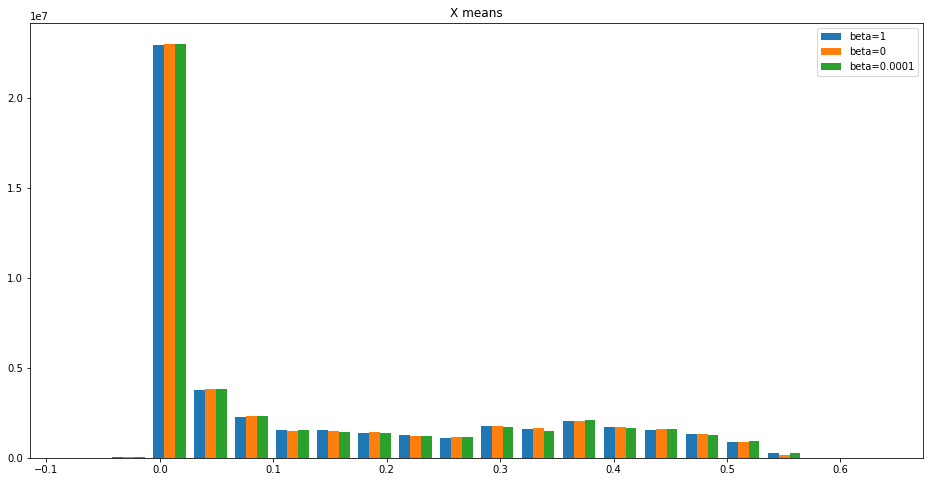

In [13]:
plt.figure(figsize=(16, 8))
plt.title('X means')
plt.hist([x_b1_mu.view(-1).numpy(), 
          x_b0_mu.view(-1).numpy(), 
          x_bsmall_mu.view(-1).numpy()], 
         bins=20, 
         label=['beta=1', 'beta=0', 'beta=0.0001'])
plt.legend()
plt.show()

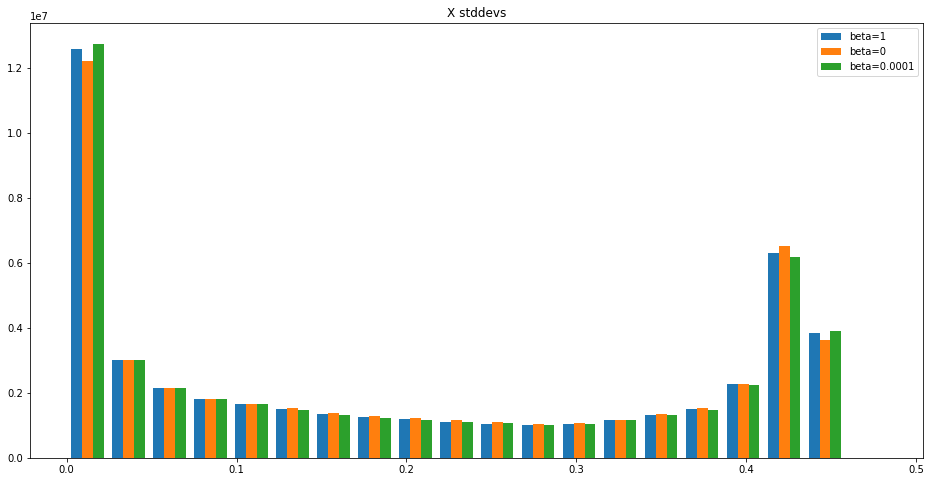

In [14]:
plt.figure(figsize=(16, 8))
plt.title('X stddevs')
plt.hist([x_b1_std.view(-1).numpy(), 
          x_b0_std.view(-1).numpy(), 
          x_bsmall_std.view(-1).numpy()], 
         bins=20, 
         label=['beta=1', 'beta=0', 'beta=0.0001'])
plt.legend()
plt.show()